# Feature selection I - selecting for feature information
> In this first out of two chapters on feature selection, you'll learn about the curse of dimensionality and how dimensionality reduction can help you overcome it. You'll be introduced to a number of techniques to detect and remove features that bring little added value to the dataset. Either because they have little variance, too many missing values, or because they are strongly correlated to other features. This is the Summary of lecture "Dimensionality Reduction in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Machine_Learning]
- image: images/heatmap_lt.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (7, 7)

## The curse of dimensionality


### Train - test split
In this chapter, you will keep working with the ANSUR dataset. Before you can build a model on your dataset, you should first decide on which feature you want to predict. In this case, you're trying to predict gender.

You need to extract the column holding this feature from the dataset and then split the data into a training and test set. The training set will be used to train the model and the test set will be used to check its performance on unseen data.

In [6]:
ansur_male = pd.read_csv('./dataset/ANSUR_II_MALE.csv')
ansur_female = pd.read_csv('./dataset/ANSUR_II_FEMALE.csv')

ansur_df = pd.concat([ansur_male, ansur_female])
# unused columns in the dataset
unused = ['Branch', 'Component', 'BMI_class', 'Height_class', 'BMI', 'weight_kg', 'stature_m']

# Drop the non-numeric columns from df
ansur_df.drop(unused, axis=1, inplace=True)

In [36]:
from sklearn.model_selection import train_test_split

# Select the Gender column as the feature to be predict (y)
y = ansur_df['Gender']

# Remove the Gender column to create the training data
X = ansur_df.drop('Gender', axis=1)

# Perform a 70% train and 30% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("{} rows in test set vs. {} in training set. {} Features.".format(
    X_test.shape[0], X_train.shape[0], X_test.shape[1]
))

1821 rows in test set vs. 4247 in training set. 91 Features.


### Fitting and testing the model
In the previous exercise, you split the dataset into `X_train`, `X_test`, `y_train`, and `y_test`. These datasets have been pre-loaded for you. You'll now create a support vector machine classifier model (`SVC()`) and fit that to the training data. You'll then calculate the accuracy on both the test and training set to detect overfitting.

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of the Support Vector Classification class
svc = SVC()

# Fit the model to the training data
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))

print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, 
                                                                       accuracy_train))

99.0% accuracy on test set vs. 99.0% on training set


Current data doesn't show overfitting. But example in datacamp shows overfitting from dataset.

In [56]:
ansur_df_overfit = pd.read_csv('./dataset/ansur_overfit.csv')

# Select the Gender column as the feature to be predict (y)
y = ansur_df_overfit['Gender']

# Remove the Gender column to create the training data
X = ansur_df_overfit.drop('Gender', axis=1)

# Perform a 70% train and 30% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("{} rows in test set vs. {} in training set. {} Features.".format(
    X_test.shape[0], X_train.shape[0], X_test.shape[1]
))

# Create an instance of the Support Vector Classification class
svc = SVC()

# Fit the model to the training data
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))

print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, 
                                                                       accuracy_train))

300 rows in test set vs. 700 in training set. 91 Features.
91.3% accuracy on test set vs. 94.7% on training set


### Accuracy after dimensionality reduction
You'll reduce the overfit with the help of dimensionality reduction. In this case, you'll apply a rather drastic form of dimensionality reduction by only selecting a single column that has some good information to distinguish between genders. You'll repeat the train-test split, model fit and prediction steps to compare the accuracy on test vs. training data.

In [67]:
# Assign just the 'neckcircumferencebase' column from ansur_df to X
X = ansur_df_overfit[['neckcircumferencebase']]

# SPlit the data, instantiate a classifier and fit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
svc = SVC()
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))

print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, 
                                                                       accuracy_train))

92.7% accuracy on test set vs. 95.0% on training set


On the full dataset the model is rubbish but with a single feature we can make good predictions? This is an example of the curse of dimensionality! The model badly overfits when we feed it too many features. It overlooks that neck circumference by itself is pretty different for males and females.

## Features with missing values or little variance


### Finding a good variance threshold
You'll be working on a slightly modified subsample of the ANSUR dataset with just head measurements 

In [68]:
head_df = pd.read_csv('./dataset/head_df.csv')

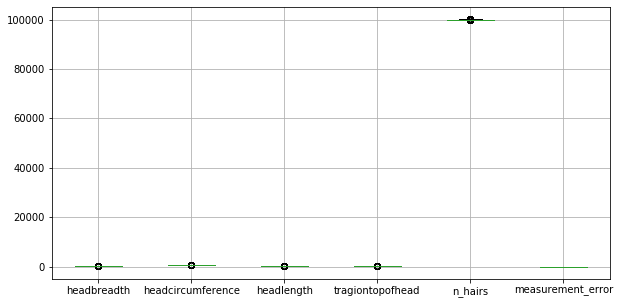

In [69]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 5));
head_df.boxplot(ax=ax);

headbreadth          1.678952e-03
headcircumference    1.029623e-03
headlength           1.867872e-03
tragiontopofhead     2.639840e-03
n_hairs              1.002552e-08
measurement_error    3.231707e-27
dtype: float64


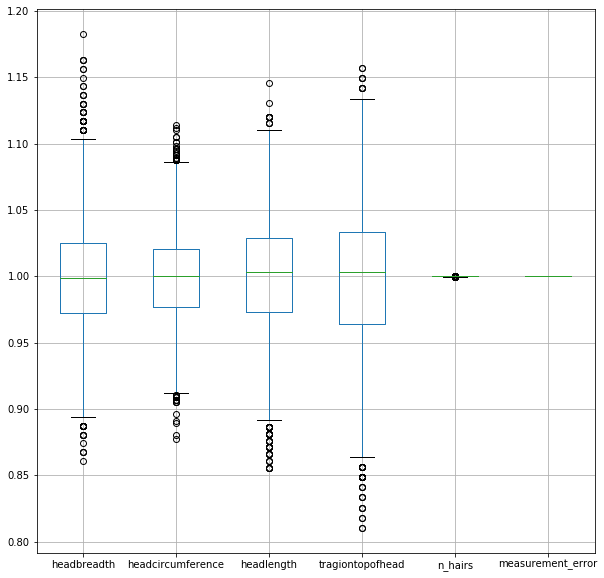

In [70]:
# Normalize the data
normalized_df = head_df / head_df.mean()

# Print the variances of the normalized data
print(normalized_df.var())

fig, ax = plt.subplots(figsize=(10, 10));
normalized_df.boxplot(ax=ax);

### Features with low variance
In the previous exercise you established that 0.001 is a good threshold to filter out low variance features in `head_df` after normalization. Now use the `VarianceThreshold` feature selector to remove these features.

In [71]:
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=0.001)

# Fit the selector to normalized head_df
sel.fit(head_df / head_df.mean())

# Create a boolean mask
mask = sel.get_support()

# Apply the mask to create a reduced dataframe
reduced_df = head_df.loc[:, mask]

print("Dimensionality reduced from {} to {}".format(head_df.shape[1], reduced_df.shape[1]))

Dimensionality reduced from 6 to 4


### Removing features with many missing values
You'll apply feature selection on the Boston Public Schools dataset which has been pre-loaded as school_df. Calculate the missing value ratio per feature and then create a mask to remove features with many missing values.

In [72]:
school_df = pd.read_csv('./dataset/Public_Schools2.csv')

In [73]:
# Create a boolean mask on whether each feature less than 50% missing values
mask = school_df.isna().sum() / len(school_df) < 0.5

# Create a reduced dataset by applying the mask
reduced_df = school_df.loc[:, mask]

print(school_df.shape)
print(reduced_df.shape)

(131, 21)
(131, 19)


## Pairwise correlation
- Correlation coefficient (r)
![corr_coef](image/correlation_coef.png)


### Visualizing the correlation matrix
Reading the correlation matrix of `ansur_df` in its raw, numeric format doesn't allow us to get a quick overview. Let's improve this by removing redundant values and visualizing the matrix using seaborn.

In [74]:
ansur_df_sample = ansur_df[['elbowrestheight', 'wristcircumference', 'anklecircumference',
                            'buttockheight', 'crotchheight']]
ansur_df_sample.columns = ['Elbow rest height', 'Wrist circumference', 
                           'Ankle circumference', 'Buttock height', 'Crotch height']
ansur_df_sample.head()

Elbow rest height  Wrist circumference  Ankle circumference  \
0                247                  175                  222   
1                232                  167                  220   
2                237                  180                  230   
3                272                  176                  230   
4                188                  188                  247   

   Buttock height  Crotch height  
0             882            877  
1             870            851  
2             901            854  
3             821            769  
4            1080           1014

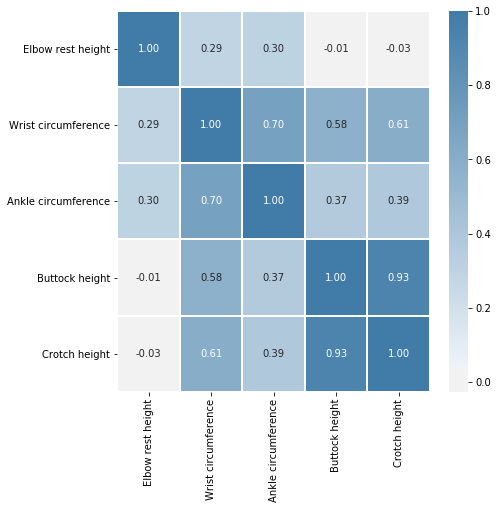

In [75]:
# Create the correlation matrix
corr = ansur_df_sample.corr()

cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr,  cmap=cmap, center=0, linewidths=1, annot=True, fmt=".2f");

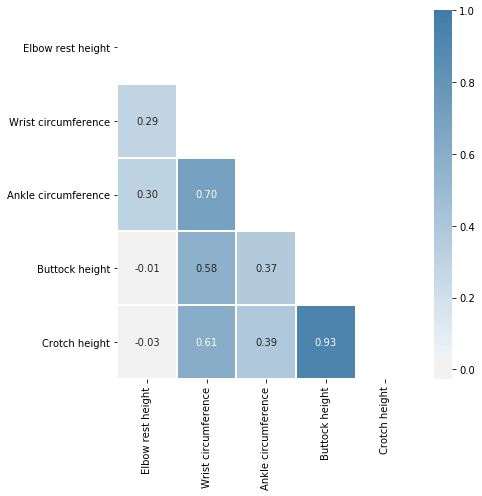

In [84]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=1, annot=True, fmt='.2f');

## Removing highly correlated features


### Filtering out highly correlated features
You're going to automate the removal of highly correlated features in the numeric ANSUR dataset. You'll calculate the correlation matrix and filter out columns that have a correlation coefficient of more than 0.95 or less than -0.95.

Since each correlation coefficient occurs twice in the matrix (correlation of A to B equals correlation of B to A) you'll want to ignore half of the correlation matrix so that only one of the two correlated features is removed. Use a mask trick for this purpose.

In [78]:
ansur_male = pd.read_csv('./dataset/ANSUR_II_MALE.csv')
ansur_df = ansur_male

In [79]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = ansur_df.corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

# Drop the features in the to_drop list
reduced_df = ansur_df.drop(to_drop, axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The reduced dataframe has 88 columns.


### Nuclear energy and pool drownings
The dataset that has been pre-loaded for you as `weird_df` contains actual data provided by the US Centers for Disease Control & Prevention and Department of Energy.

Let's see if we can find a pattern.

In [80]:
weird_df = pd.read_csv('./dataset/weird_df.csv')

In [81]:
# Print the first five lines of weird_df
print(weird_df.head())

   pool_drownings  nuclear_energy
0             421           728.3
1             465           753.9
2             494           768.8
3             538           780.1
4             430           763.7


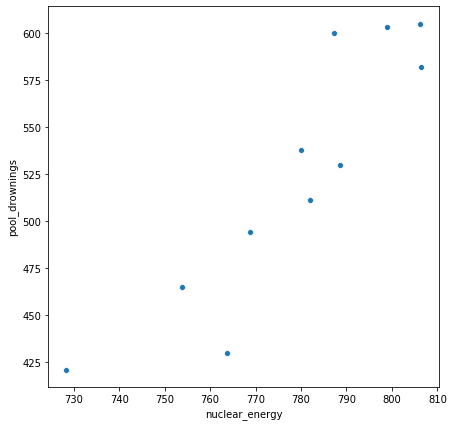

In [82]:
# Put nuclear energy production on the x-axis and the number of pool drownings on the y-axis
sns.scatterplot(x='nuclear_energy', y='pool_drownings', data=weird_df);

In [83]:
# Print out the correlation matrix of weird_df
print(weird_df.corr())

                pool_drownings  nuclear_energy
pool_drownings        1.000000        0.901179
nuclear_energy        0.901179        1.000000


But correlation of the data does not imply causation.